In [1]:
import math
import joblib
import tf_keras as keras

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tf_keras import activations, layers, initializers
from tf_keras.models import Model

from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
u_in = np.load("data/poisson1Dinput.npy")
g_uy_out = np.load("data/poisson1Doutput.npy") * 20

In [4]:
u_in = np.expand_dims(u_in, axis=1)
g_uy_out = np.expand_dims(g_uy_out, axis=-1)

In [5]:
u_in.shape

(2000, 1, 100)

In [6]:
n_total = 1000
n_test = 400
rand = 42
u_in_use, g_uy_out_use = u_in[:n_total,...], g_uy_out[:n_total,...]

idxs = np.arange(u_in_use.shape[0])
idx_train, idx_test = train_test_split(idxs, test_size=n_test/n_total, 
                                        random_state=rand)

u_train, g_train = u_in_use[idx_train,:], g_uy_out_use[idx_train,:]
u_test, g_test = u_in_use[idx_test,:], g_uy_out_use[idx_test,:]

n_grid = 100
y_space_train = np.expand_dims(np.tile(np.linspace(0,1,n_grid),(u_train.shape[0],1)), axis=-1)
y_space_test = np.expand_dims(np.tile(np.linspace(0,1,n_grid),(u_test.shape[0],1)), axis=-1)

In [7]:
y_space_train.shape

(600, 100, 1)

In [8]:
def build_mlp(inputs, output_features: int, 
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    
    # Create hidden layers with tanh activation
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_features, activation='silu')(x)
    
    # Output layer with linear activation for regression
    outputs = layers.Dense(output_features, activation='linear')(x)
    
    return outputs

In [9]:
def deeponet(y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
    """_summary_

    Args:
        y_in_size (tuple): spatial input size
        u_in_size (tuple): function input size
        trunk_params (dict): trunk net parameters
        branch_params (dict): branch net parameters
        out_feat (int, optional): number of output feature. Defaults to 1.

    Returns:
        keras.Model: output model
    """
    y_input = layers.Input(y_in_size)
    u_input = layers.Input(u_in_size)

    # Trunk layer
    trunk_out = build_mlp(y_input, trunk_params["output_features"], 
                          trunk_params["hidden_features"], trunk_params["num_hidden_layers"])
    
    # Branch layer
    branch_out = build_mlp(u_input, branch_params["output_features"], 
                          branch_params["hidden_features"], branch_params["num_hidden_layers"])

    # Multiply trunk and branch
    mult_out = layers.Multiply()([trunk_out, branch_out])

    out = layers.Dense(out_feat,use_bias=False)(mult_out)

    model = Model(inputs=[y_input, u_input], outputs=out, name="DeepONet")

    return model


In [10]:
trunk_params=dict()
trunk_params["output_features"] = 75
trunk_params["hidden_features"] = 75
trunk_params["num_hidden_layers"] = 4

branch_params=dict()
branch_params["output_features"] = 75
branch_params["hidden_features"] = 75
branch_params["num_hidden_layers"] = 4

In [11]:
onet = deeponet(y_in_size=(100,1), u_in_size=(1,100), trunk_params=trunk_params, 
                branch_params=branch_params, out_feat=1)
onet.summary()

Model: "DeepONet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1, 100)]             0         []                            
                                                                                                  
 dense (Dense)               (None, 100, 75)              150       ['input_1[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 1, 75)                7575      ['input_2[0][0]']             
                                                                                           

In [12]:
onet.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=["mse"]
)

In [13]:
history = onet.fit(x=[y_space_train,u_train], y=g_train, batch_size=256, epochs=2000, verbose=1)

Epoch 1/2000
3/3 [==============================] - 1s 28ms/step - loss: 1.1087 - mse: 1.1087
Epoch 2/2000
3/3 [==============================] - 0s 22ms/step - loss: 1.0775 - mse: 1.0775
Epoch 3/2000
3/3 [==============================] - 0s 27ms/step - loss: 0.9761 - mse: 0.9761
Epoch 4/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.7459 - mse: 0.7459
Epoch 5/2000
3/3 [==============================] - 0s 26ms/step - loss: 0.4862 - mse: 0.4862
Epoch 6/2000
3/3 [==============================] - 0s 24ms/step - loss: 0.4541 - mse: 0.4541
Epoch 7/2000
3/3 [==============================] - 0s 34ms/step - loss: 0.3466 - mse: 0.3466
Epoch 8/2000
3/3 [==============================] - 0s 25ms/step - loss: 0.3558 - mse: 0.3558
Epoch 9/2000
3/3 [==============================] - 0s 24ms/step - loss: 0.3546 - mse: 0.3546
Epoch 10/2000
3/3 [==============================] - 0s 25ms/step - loss: 0.3214 - mse: 0.3214
Epoch 11/2000
3/3 [==============================] - 0s 24m

In [14]:
preds = onet.predict([y_space_test, u_test])

13/13 [==============================] - 0s 6ms/step


In [15]:
preds.shape

(400, 100, 1)

In [16]:
g_test.shape

(400, 100, 1)

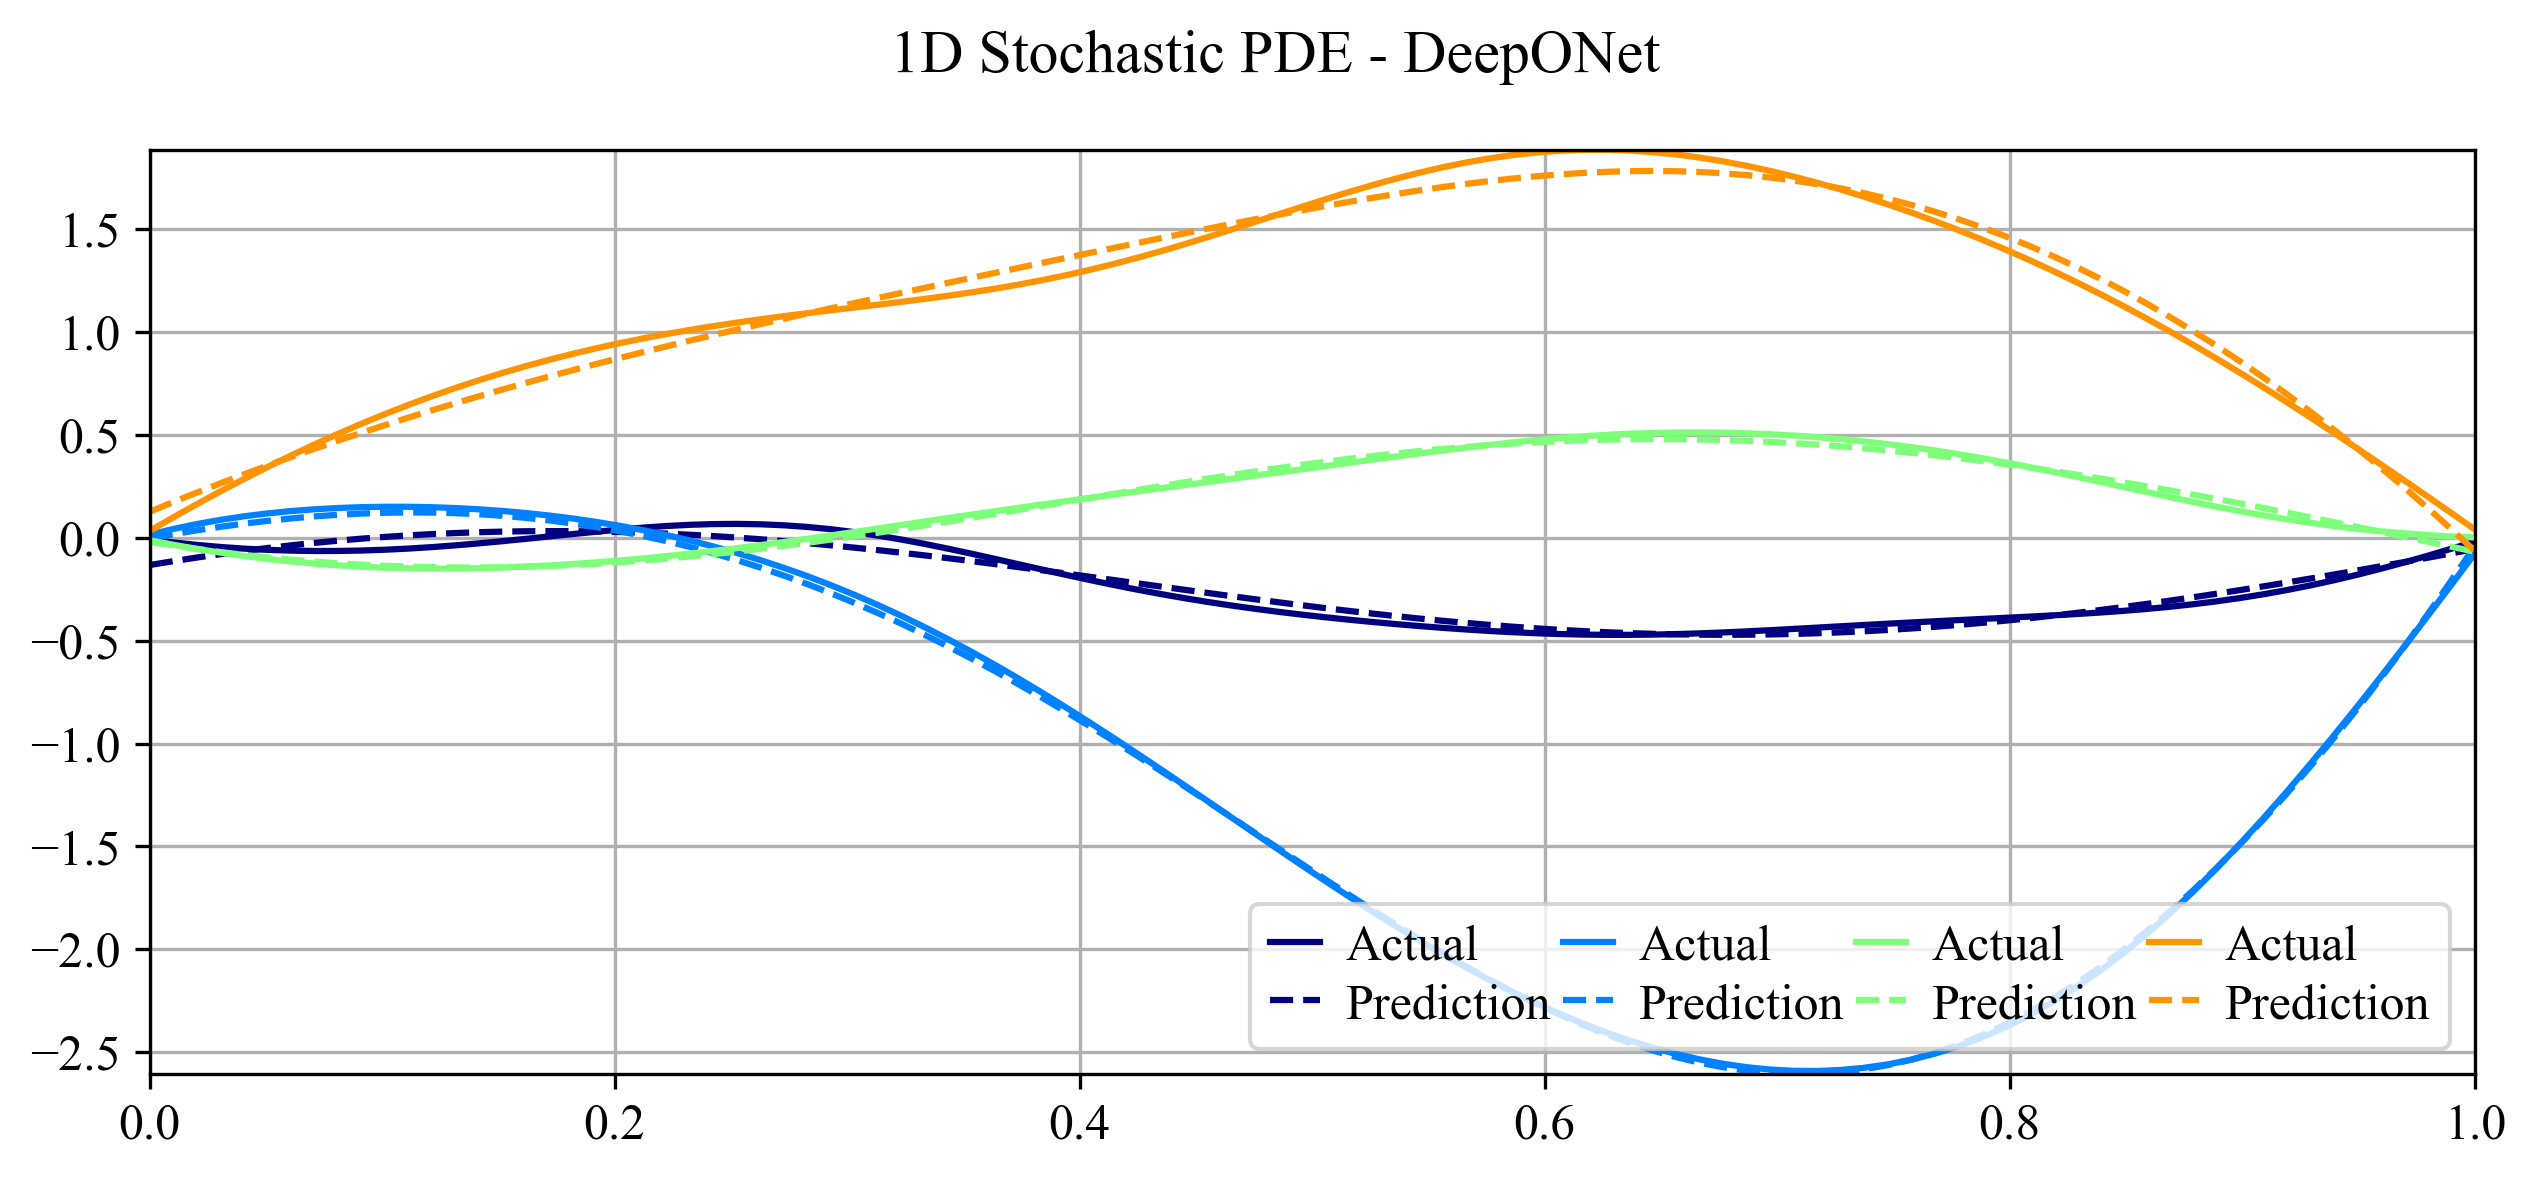

In [17]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - DeepONet')

index = 0
for i in [1,2,5,7]:
    plt.plot(y_space_test[0,:,0], g_test[i, :], color=colors[index], label='Actual')
    plt.plot(y_space_test[0,:,0], preds[i,:], '--', color=colors[index], label='Prediction')
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)